In [24]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Load the Pima Indians Diabetes dataset        
data = pd.read_csv('Pima-Indian-Dataset.csv')
# Basic data inspection
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:\n", data.head())
print("\nMissing Values (Zeros):\n", data.eq(0).sum())
print("\nClass Distribution:\n", data['Outcome'].value_counts(normalize=True))

Dataset Shape: (768, 9)

First 5 rows:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Missing Values (Zeros):
 Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age          

Number of components after PCA: 7
Explained variance ratio: 0.9614
Class Distribution:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64
Optimal K for KMeans: 35
Optimal K for KMeans_PCA: 35
Optimal K for MiniBatchKMeans: 45
Optimal K for Spectral: 48
KMeans KNN Error Rate: 24.03% (Best k: 30)
KMeans_PCA KNN Error Rate: 24.03% (Best k: 30)
MiniBatchKMeans KNN Error Rate: 26.62% (Best k: 30)
Spectral KNN Error Rate: 27.92% (Best k: 25)
BIRCH KNN Error Rate: 26.62% (Best k: 30)

10-Fold Cross-Validation Error Rates:
KMeans KNN 10-Fold CV Error Rate: 24.42%
KMeans_PCA KNN 10-Fold CV Error Rate: 24.42%
MiniBatchKMeans KNN 10-Fold CV Error Rate: 24.42%
Spectral KNN 10-Fold CV Error Rate: 23.78%
BIRCH KNN 10-Fold CV Error Rate: 24.42%


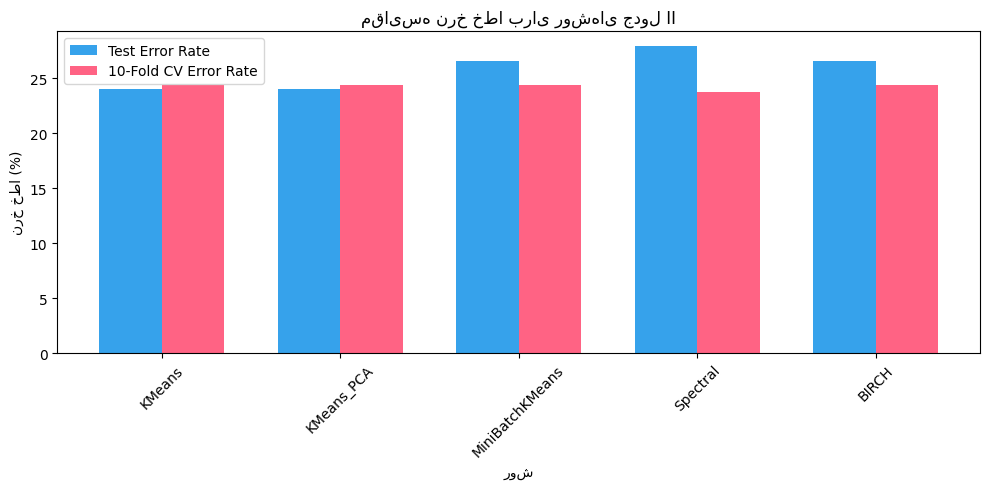

In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- Preprocessing Section ---
# Load the Pima Indians Diabetes dataset
data = pd.read_csv('Pima-Indian-Dataset.csv')

# Handle missing values (replace zeros with NaN and impute using KNNImputer)
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[cols_with_zeros] = data[cols_with_zeros].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=5)
data[cols_with_zeros] = imputer.fit_transform(data[cols_with_zeros])

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets (80:20 as per article)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

print(f"Number of components after PCA: {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
print("Class Distribution:")
print(y_train.value_counts(normalize=True))

# --- Supervised Classification Section ---
# Define clustering methods from Table II
clustering_methods = {
    'KMeans': KMeans(random_state=42),
    'KMeans_PCA': KMeans(random_state=42),  # Already using PCA-processed data
    'MiniBatchKMeans': MiniBatchKMeans(random_state=42, batch_size=100),
    'Spectral': SpectralClustering(random_state=42, affinity='nearest_neighbors'),
    'BIRCH': Birch(n_clusters=None)
}

# Step 1: Determine optimal number of clusters
optimal_k = {}
for name, model in clustering_methods.items():
    if name == 'BIRCH':
        optimal_k[name] = None
        continue
    silhouette_scores = []
    for k in range(20, 51):  # Test range 20 to 50 clusters
        model.set_params(n_clusters=k)
        labels = model.fit_predict(X_train)
        score = silhouette_score(X_train, labels)
        silhouette_scores.append((k, score))
    optimal_k[name] = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"Optimal K for {name}: {optimal_k[name]}")

# Step 2: Commission selection and KNN classification
knn_results = {}
for name, model in clustering_methods.items():
    if name == 'BIRCH':
        model.fit(X_train)
        labels = model.labels_
        centroids = np.array([X_train[labels == i].mean(axis=0) for i in np.unique(labels)])
    elif name == 'Spectral':
        model.set_params(n_clusters=optimal_k[name])
        model.fit(X_train)
        labels = model.labels_
        centroids = np.array([X_train[labels == i].mean(axis=0) for i in np.unique(labels)])
    else:
        model.set_params(n_clusters=optimal_k[name])
        model.fit(X_train)
        labels = model.labels_
        centroids = model.cluster_centers_

    # Select commissions (closest to centroids, 50% of each cluster)
    commissions = []
    for cluster_id in np.unique(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        if len(cluster_indices) == 0:
            continue
        cluster_data = X_train[cluster_indices]
        centroid = centroids[cluster_id]
        distances = np.linalg.norm(cluster_data - centroid, axis=1)
        n_samples = max(1, len(cluster_indices) // 2)
        selected_indices = cluster_indices[np.argsort(distances)[:n_samples]]
        commissions.extend(selected_indices)

    X_train_commissions = X_train[commissions]
    y_train_commissions = y_train.iloc[commissions]

    # KNN with GridSearch for optimal k, using weights='distance'
    knn = KNeighborsClassifier(weights='distance')
    param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 15, 20, 25, 30]}
    grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_train_commissions, y_train_commissions)

    # Evaluate on test set
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    error_rate = 100 * (1 - accuracy)
    knn_results[name] = {'error_rate': error_rate, 'best_k': grid_search.best_params_['n_neighbors']}
    print(f"{name} KNN Error Rate: {error_rate:.2f}% (Best k: {grid_search.best_params_['n_neighbors']})")

# Step 3: 10-Fold Cross-Validation
print("\n10-Fold Cross-Validation Error Rates:")
for name, result in knn_results.items():
    knn = KNeighborsClassifier(n_neighbors=result['best_k'], weights='distance')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    error_rate_cv = 100 * (1 - scores.mean())
    knn_results[name]['cv_error_rate'] = error_rate_cv
    print(f"{name} KNN 10-Fold CV Error Rate: {error_rate_cv:.2f}%")

# Step 4: Visualize results
results = knn_results
labels = list(results.keys())
error_rates = [results[name]['error_rate'] for name in labels]
cv_error_rates = [results[name]['cv_error_rate'] for name in labels]

plt.figure(figsize=(10, 5))
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, error_rates, width, label='Test Error Rate', color='#36A2EB')
plt.bar(x + width/2, cv_error_rates, width, label='10-Fold CV Error Rate', color='#FF6384')
plt.xlabel('روش')
plt.ylabel('نرخ خطا (%)')
plt.title('مقایسه نرخ خطا برای روش‌های جدول II')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()